In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nbsupport import insertions as nb_ins

sns.set_style('white')

# Insertion statistics

In [2]:
samples = (pd.read_csv('../data/raw/sb/samples.txt', sep='\t')
             .query('include_shearsplink == True'))
samples.shape

(99, 11)

## All insertions (incl. non-cis)

Number of insertions: 3230
Median insertions per sample: 29.0


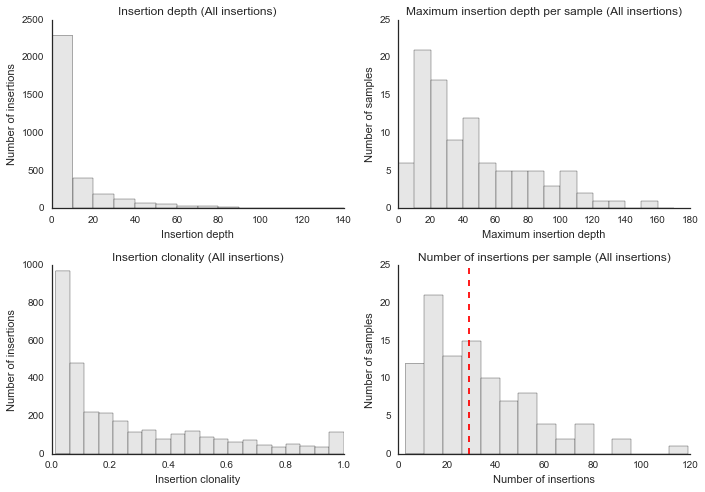

In [35]:
insertions_all = (pd.read_csv('../data/processed/sb/shear_splink/all/insertions.txt',
                              sep='\t', dtype={'sample': 'category'})
                    .pipe(nb_ins.annotate_with_clonality))

# Print some basic statistics.
print('Number of insertions: {}'.format(insertions_all['id'].nunique()))
print('Median insertions per sample: {}'.format(
        insertions_all.groupby('sample')['id'].nunique().median()))

# Plot stats.
fig, _ = nb_ins.plot_insertion_stats(
    insertions_all, suffix=' (All insertions)',
    fig_kws={'figsize': (10, 7)}, color=(0.9, 0.9, 0.9))

# Plot again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, _ = nb_ins.plot_insertion_stats(
        insertions_all, fig_kws=dict(figsize=(6, 4)),
        color=(0.9, 0.9, 0.9), suffix=' (All insertions)')

fig.savefig('../reports/supplemental/figures/fig_s3_ins_stats.pdf', bbox_inches='tight')
plt.close(fig)

## CIS insertions

Number of insertions: 518
Number of CIS: 58
Insertions per sample: 5.0
Number of genes: 30


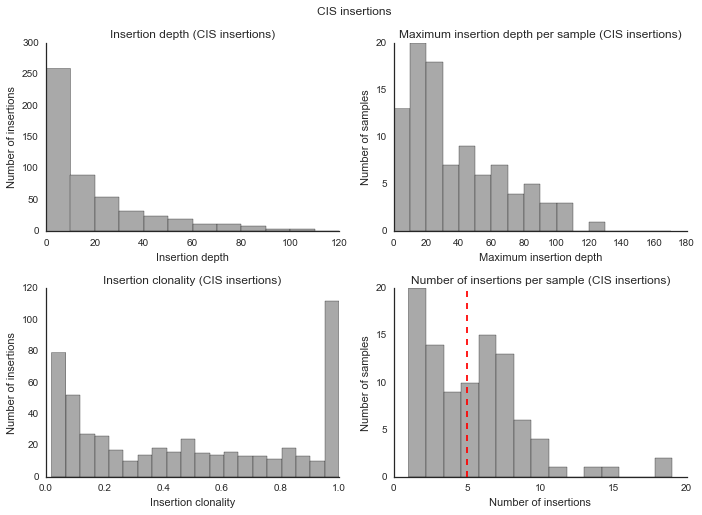

In [37]:
# Read insertions and cis sites.
insertions = (pd.read_csv('../data/processed/sb/shear_splink/all/insertions.cis.rbm.txt',
                          sep='\t', dtype={'sample': 'category'})
                .pipe(nb_ins.annotate_with_clonality))

cis_sites = pd.read_csv('../data/processed/sb/shear_splink/all/insertions.cis.sites.txt', sep='\t')

# Print some basic statistics.
print('Number of insertions: {}'.format(insertions['id'].nunique()))
print('Number of CIS: {}'.format(cis_sites.shape[0]))
print('Insertions per sample: {}'.format(
        insertions.groupby('sample')['id'].nunique().median()))
print('Number of genes: {}'.format(insertions['gene_name'].nunique()))

# Plot some basis stats.
fig, _ = nb_ins.plot_insertion_stats(
    insertions, fig_kws={'figsize': (10, 7)}, 
    suffix=' (CIS insertions)', color='darkgrey')
fig.suptitle('CIS insertions', fontsize=12, y=1.02);

# Plot again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, _ = nb_ins.plot_insertion_stats(
        insertions, fig_kws=dict(figsize=(6, 4)), 
        suffix=' (CIS insertions)', color='darkgrey')

fig.savefig('../reports/supplemental/figures/fig_s3_cis_stats.pdf', bbox_inches='tight')
plt.close(fig)

# Sample overview

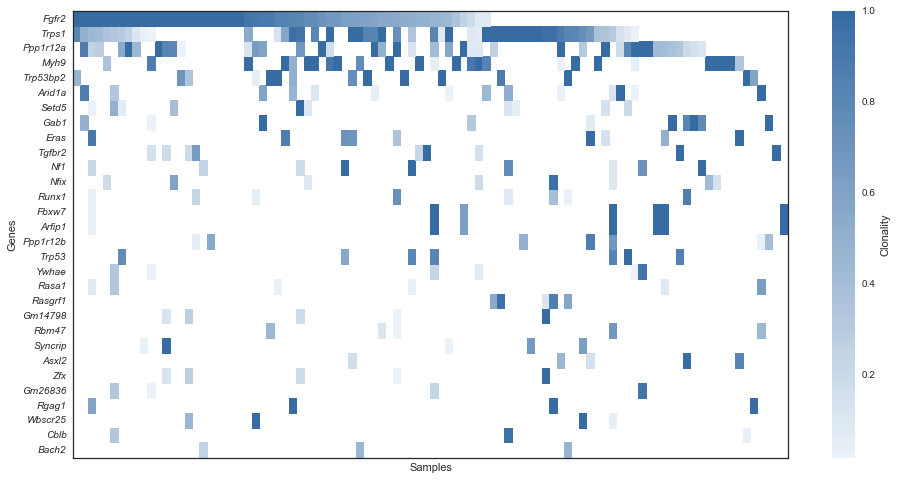

In [5]:
from nbsupport import insertions as nb_ins

fig, ax = plt.subplots(figsize=(16, 8))
nb_ins.plot_insertion_matrix(insertions, ax=ax)

# Draw again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(9.6, 4))
    nb_ins.plot_insertion_matrix(insertions, ax=ax) 
    fig.savefig('../reports/figures/fig_3_overview.pdf', bbox_inches='tight')
    plt.close()

# Subtype enrichment

## ILC samples

In [124]:
from IPython.display import display
from nbsupport.enrichment import associations as nb_assoc

# Get subtypes.
nmf_subtypes = pd.read_csv('../data/processed/sb/nmf/subtypes.txt',
                           sep='\t', index_col=0)

# Summarize gene clonality per sample.
sample_mat = nb_ins.clonality_matrix(insertions).T > 0
    
# Test individual clusters.
res_subtype = nb_assoc.test_associations(
    nmf_subtypes[['subtype']], sample_mat,
    alternative='greater', labels=('cluster', 'gene'))

print('Subtypes')
display(res_subtype.query('p_value_corr < 0.1'))

# Test merged clusters.
res_subtype_merged = nb_assoc.test_associations(
    nmf_subtypes[['subtype_merged']], sample_mat,
    alternative='greater', labels=('cluster', 'gene'))

print('Merged subtypes')
display(res_subtype_merged.query('p_value_corr < 0.1'))

Subtypes


,cluster,gene,p_value,p_value_corr
65,subtype_ILC-2,Eras,0.000411,0.024662
113,subtype_Squamous-like,Tgfbr2,0.000076,0.009166


Merged subtypes


,cluster,gene,p_value,p_value_corr
83,subtype_merged_Squamous-like,Tgfbr2,0.000076,0.006874


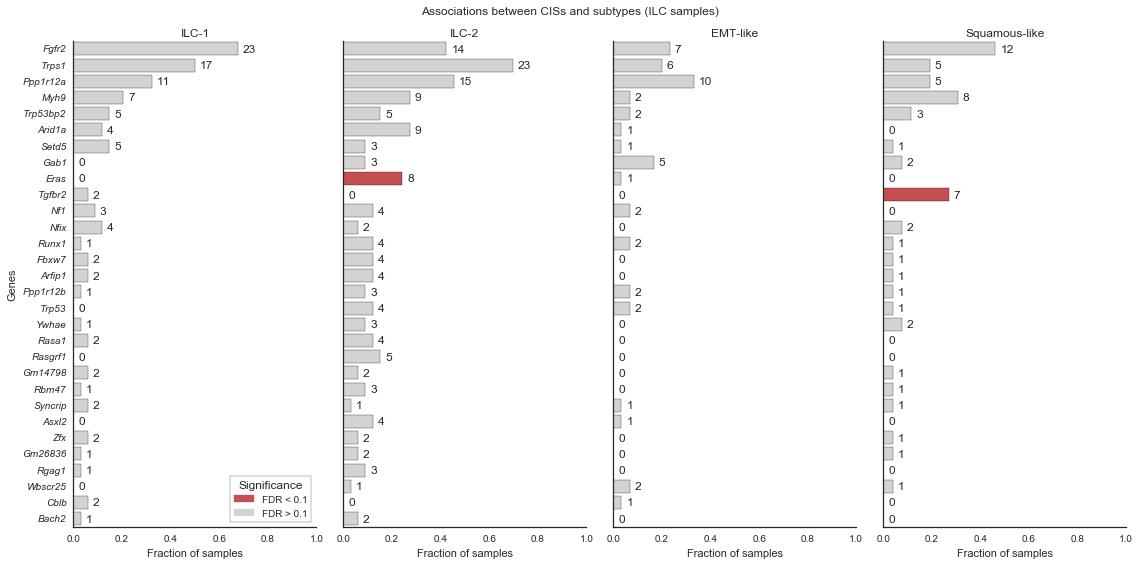

In [125]:
subtype_order = ['ILC-1', 'ILC-2', 'EMT-like', 'Squamous-like']

# Rank genes by frequency.
ranked_genes = list(insertions.groupby('gene_name')['sample']
                              .nunique().sort_values(ascending=False)
                              .index)

# Get associations with subtypes.
subtype_assocs = {cluster.split('_')[1]: list(grp['gene'])
                  for cluster, grp in res_subtype.query('p_value_corr < 0.1')
                                                 .groupby('cluster')}

# Plot counts per subtype for all genes.
shared_kws = dict(
    highlight=subtype_assocs,
    highlight_labels=('FDR < 0.1', 'FDR > 0.1'),
    legend_kws=dict(title='Significance'),
    col_order=subtype_order)

g = nb_ins.plot_subtype_counts(
    insertions, nmf_subtypes['subtype'], order=ranked_genes,
    size=8, aspect=0.5, **shared_kws)

g.fig.suptitle('Associations between CISs and subtypes (ILC samples)', fontsize=12)
g.fig.subplots_adjust(top=0.92)

# Draw again for paper with slightly different scaling.
with sns.plotting_context('paper', font_scale=0.7):
    g = nb_ins.plot_subtype_counts(
        insertions, nmf_subtypes['subtype'], size=3.8, order=ranked_genes,
        aspect=0.45, annotate_kws={'fontsize': 5}, **shared_kws)
    g.fig.suptitle('Associations between CISs and subtypes (ILC samples)', fontsize=7)
    g.fig.subplots_adjust(top=0.9)

g.savefig('../reports/supplemental/figures/fig_s4_subtype_assocs.pdf', bbox_inches='tight')
plt.close(g.fig);

## All samples

In [126]:
# Summarize gene clonality per sample.
insertions_all_samples = (pd.read_csv('../data/processed/sb/shear_splink_full/'
                                      'all/insertions.cis.rbm.txt', sep='\t')
                            .pipe(nb_ins.annotate_with_clonality))
sample_mat_all = nb_ins.clonality_matrix(insertions_all_samples).T > 0

# Test individual clusters.
res_subtype_all = nb_assoc.test_associations(
    nmf_subtypes[['subtype']], sample_mat_all,
    alternative='greater', labels=('cluster', 'gene'))

print('Subtypes')
display(res_subtype_all.query('p_value_corr < 0.1'))

# Test merged clusters.
res_subtype_merged_all = nb_assoc.test_associations(
    nmf_subtypes[['subtype_merged']], sample_mat_all,
    alternative='greater', labels=('cluster', 'gene'))

print('Merged subtypes')
display(res_subtype_merged_all.query('p_value_corr < 0.1'))

Subtypes


,cluster,gene,p_value,p_value_corr
63,subtype_ILC-2,Arid1a,3.323740e-03,0.082429
67,subtype_ILC-2,Eras,3.212765e-04,0.019919
81,subtype_ILC-2,Rasgrf1,9.711229e-04,0.030105
90,subtype_ILC-2,Trps1,4.898831e-04,0.020249
118,subtype_Squamous-like,Tgfbr2,4.778249e-07,0.000059


Merged subtypes


,cluster,gene,p_value,p_value_corr
59,subtype_merged_ILC,Trps1,3.281936e-04,0.015261
87,subtype_merged_Squamous-like,Tgfbr2,4.778249e-07,0.000044


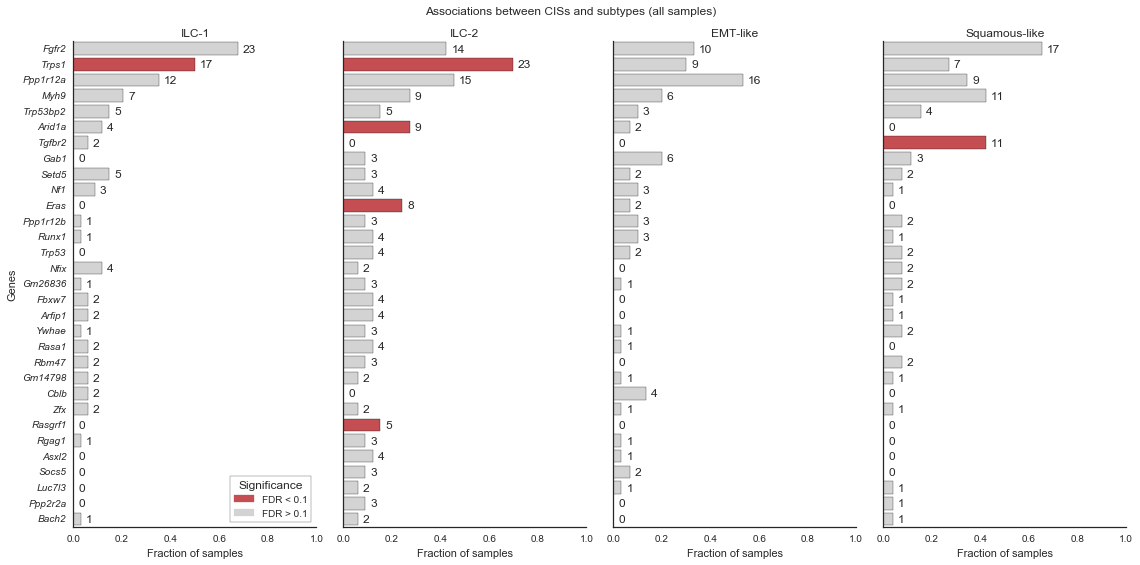

In [128]:
# Get associations with subtypes.
subtype_assocs_all = {
    cluster.split('_')[1]: list(grp['gene'])
    for cluster, grp in res_subtype_all.query('p_value_corr < 0.1')
                                       .groupby('cluster')}

# Add Trps1 (enriched in combined ILC groups).
if 'ILC-1' not in subtype_assocs_all:
    subtype_assocs_all['ILC-1'] = []

subtype_assocs_all['ILC-1'].append('Trps1') 
subtype_assocs_all['ILC-2'].append('Trps1') 

order = list(insertions_all_samples
             .groupby('gene_name')
             ['sample'].nunique()
             .sort_values(ascending=False)
             .index)
         
# Plot counts per subtype for all genes.
shared_kws = dict(
    order=order,
    col_order=subtype_order,
    highlight=subtype_assocs_all,
    highlight_labels=('FDR < 0.1', 'FDR > 0.1'),
    legend_kws=dict(title='Significance'))

g = nb_ins.plot_subtype_counts(
    insertions_all_samples, nmf_subtypes['subtype'],
    size=8, aspect=0.5, **shared_kws)

g.fig.suptitle('Associations between CISs and subtypes (all samples)', fontsize=12)
g.fig.subplots_adjust(top=0.92)

# Draw again for paper with slightly different scaling.
with sns.plotting_context('paper', font_scale=0.7):
    g = nb_ins.plot_subtype_counts(
        insertions_all_samples, nmf_subtypes['subtype'], size=3.8,
        aspect=0.45, annotate_kws={'fontsize': 5}, **shared_kws)
    g.fig.suptitle('Associations between CISs and subtypes (all samples)', fontsize=7)
    g.fig.subplots_adjust(top=0.9)

g.savefig('../reports/supplemental/figures/fig_s4_subtype_assocs_all_samples.pdf', bbox_inches='tight')
plt.close(g.fig);

# Hit prioritization

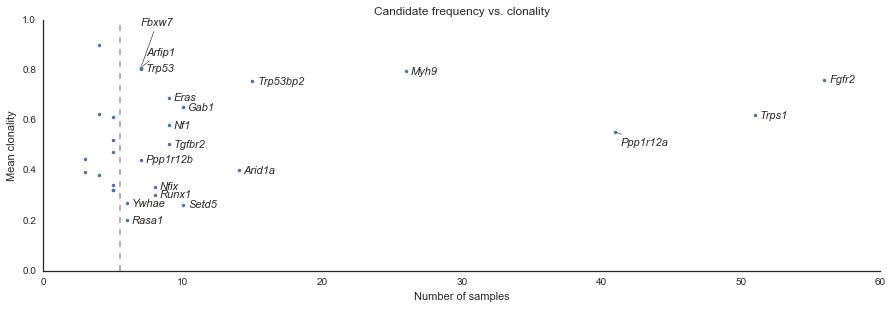

In [63]:
# Label offsets.
offsets = {'Ppp1r12a': (5, -10),
           'Fbxw7': (0, 45),
           'Arfip1': (5, 15)}

# Draw plot.
fig, ax = plt.subplots(figsize=(15, 4.5))
nb_ins.plot_gene_clonality(
    insertions, ax=ax, label_offsets=offsets, label_min_freq=6,
    label_kws=dict(fontstyle='italic', fontsize=11))
ax.axvline(5.5, color='darkgrey', linestyle='dashed', zorder=0)

# Draw again for paper with slightly different scaling.
offsets = {
    'Nfix': (5, 2),
    'Ywhae': (5, -2),
    'Eras': (5, 2),
    'Arfip1': (5, 5),
    'Trp53': (5, -5)
}

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(8.5, 1.7))
    nb_ins.plot_gene_clonality(
        insertions, ax=ax, label_offsets=offsets, label_min_freq=6,
        label_kws=dict(fontstyle='italic', fontsize=6), markersize=6)
    ax.set_title('')
    ax.axvline(5.5, color='darkgrey', linestyle='dashed', zorder=0)

fig.savefig('../reports/supplemental/figures/fig_s5_freq_clonality.pdf', bbox_inches='tight')
plt.close(fig)

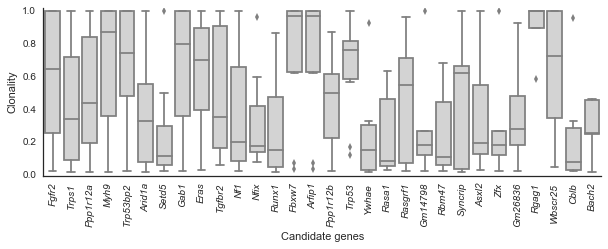

In [49]:
# Order genes by their ranking.
rank_order = list(insertions.groupby('gene_name')
                            ['sample'].nunique()
                            .sort_values(ascending=False)
                            .index)

# Plot clonality of insertions.
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(data=insertions, x='gene_name', y='clonality',
            ax=ax, color='lightgrey', order=rank_order)

ax.set_xlabel('Candidate genes')
ax.set_ylabel('Clonality')
ax.set_ylim(0, 1.02)

plt.setp(ax.get_xticklabels(), rotation=90, fontstyle='italic')
sns.despine()

# Plot again for paper.
with sns.plotting_context('paper', font_scale=0.7): 
    fig, ax = plt.subplots(figsize=(8.5, 1.5))
    sns.boxplot(data=insertions, x='gene_name', y='clonality',
                ax=ax, color='lightgrey', order=rank_order,
                linewidth=0.5, fliersize=2)

    ax.set_xlabel('Candidate genes')
    ax.set_ylabel('Clonality')
    ax.set_ylim(0, 1.02)
    
    sns.despine()

    plt.setp(ax.get_xticklabels(), rotation=90, fontstyle='italic')

fig.savefig('../reports/supplemental/figures/fig_s5_clonality.pdf',
            bbox_inches='tight')    
plt.close(fig)

# Orientation bias

## Sense/antisense fraction

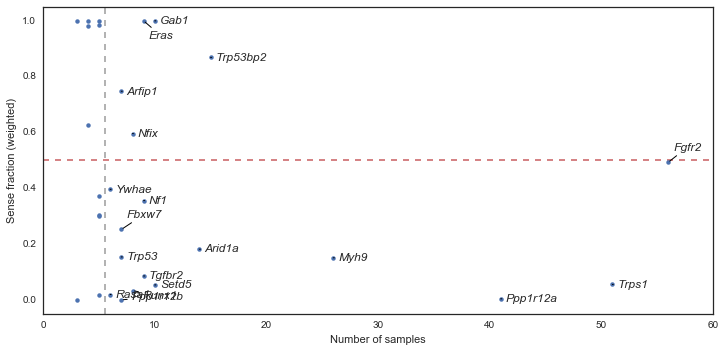

In [10]:
label_offsets = {'Eras': (5, -15), 
                 'Fbxw7': (5, 15), 
                 'Fgfr2': (5, 15),
                 'Ppp1r12b': (10, 3),
                 'Rasgrf1': (-5, -50),
                 'Runx1': (10, -5)}

fig = nb_ins.plot_orientation_bias(
    insertions, min_samples=5.5,
    label_offsets=label_offsets)

# Draw again for paper.
label_offsets = {'Eras': (5, -10), 
                 'Fgfr2': (5, 15),
                 'Tgfbr2': (5, 2),
                 'Rasa1': (-35, 8),
                 'Ppp1r12b': (-42, 22),
                 'Runx1': (5, -5)}

with sns.plotting_context('paper', font_scale=0.7):
    fig = nb_ins.plot_orientation_bias(
        insertions, min_samples=5.5,
        label_offsets=label_offsets, figsize=(8, 2.5)) 

fig.savefig('../reports/figures/fig_3_bias.pdf', bbox_inches='tight')
plt.close()

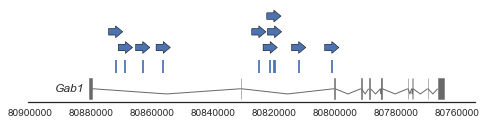

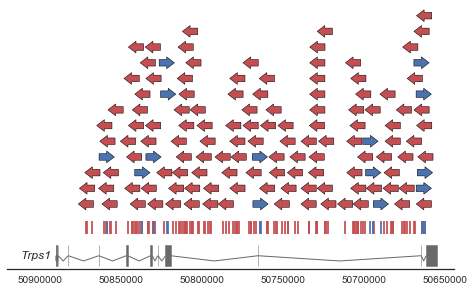

In [91]:
from nbsupport.insertions import plot_insertion_track

plot_insertion_track(insertions, region=('8', 80764438, 80880519), 
                     gene='Gab1', padding=(20000, 10000), reverse=True);

plot_insertion_track(insertions, region=('15', 50654752, 50890463), 
                     gene='Trps1', padding=(30000, 10000), reverse=True);

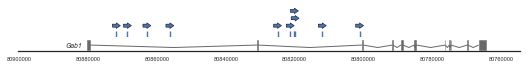

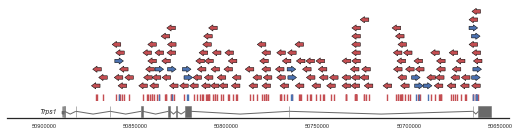

In [92]:
with sns.plotting_context('paper', font_scale=0.7):
    fig = plot_insertion_track(
        insertions, region=('8', 80764438, 80880519), figsize=(9, 0.8),
        gene='Gab1', padding=(20000, 10000), reverse=True, ins_ratio=1/50);
    fig.savefig('../reports/supplemental/figures/fig_s5_gab1.pdf', bbox_inches='tight')
    
    fig = plot_insertion_track(
        insertions, region=('15', 50654752, 50890463), figsize=(9, 2),
        gene='Trps1', padding=(30000, 10000), reverse=True, ins_ratio=1/50);
    fig.savefig('../reports/supplemental/figures/fig_s5_trps1.pdf', bbox_inches='tight')

## IM-Fusion diff-expression

In [13]:
from imfusion.expression.counts import read_exon_counts
from imfusion.expression.test import test_de

#?test_de
name_map = dict(zip(samples['rnaseq_id'], samples['sample']))
exon_counts = (read_exon_counts('../data/processed/sb/rnaseq/exon_counts.txt')
               .rename(columns=name_map))

exon_counts.head()

12SKA095-R3  12SKA136-L2  \
gene_id            chr start   end     strand                             
ENSMUSG00000090025 1   3054233 3054733 +                 0            0   
ENSMUSG00000064842 1   3102016 3102125 +                 0            0   
ENSMUSG00000051951 1   3205901 3206522 -                 0            0   
                       3206523 3207317 -                 0            0   
                       3213439 3213608 -                 2            0   

                                               13SKA010-R2  12SKA102-R3  \
gene_id            chr start   end     strand                             
ENSMUSG00000090025 1   3054233 3054733 +                 0            0   
ENSMUSG00000064842 1   3102016 3102125 +                 0            0   
ENSMUSG00000051951 1   3205901 3206522 -                 0            1   
                       3206523 3207317 -                 0            0   
                       3213439 3213608 -                 0            0   

                                               13SKA011-L3  11KOU028-L5  \
gene_id            chr start   end     strand                             
ENSMUSG00000090025 1   3054233 3054733 +                 0            0   
ENSMUSG00000064842 1   3102016 3102125 +                 0            0   
ENSMUSG00000051951 1   3205901 3206522 -                 0            1   
                       3206523 3207317 -                 0            0   
                       3213439 3213608 -                 0            0   

                                               12SKA022  12SKA079-L3  \
gene_id            chr start   end     strand                          
ENSMUSG00000090025 1   3054233 3054733 +              0            0   
ENSMUSG00000064842 1   3102016 3102125 +              0            0   
ENSMUSG00000051951 1   3205901 3206522 -              1            1   
                       3206523 3207317 -              0            1   
                       3213439 3213608 -              0            0   

                                               12SKA084-L3  \
gene_id            chr start   end     strand                
ENSMUSG00000090025 1   3054233 3054733 +                 0   
ENSMUSG00000064842 1   3102016 3102125 +                 0   
ENSMUSG00000051951 1   3205901 3206522 -                 0   
                       3206523 3207317 -                 0   
                       3213439 3213608 -                 0   

                                               2800_12_12SKA060-R3  \
gene_id            chr start   end     strand                        
ENSMUSG00000090025 1   3054233 3054733 +                         0   
ENSMUSG00000064842 1   3102016 3102125 +                         0   
ENSMUSG00000051951 1   3205901 3206522 -                         0   
                       3206523 3207317 -                         0   
                       3213439 3213608 -                         0   

                                                      ...           \
gene_id            chr start   end     strand         ...            
ENSMUSG00000090025 1   3054233 3054733 +              ...            
ENSMUSG00000064842 1   3102016 3102125 +              ...            
ENSMUSG00000051951 1   3205901 3206522 -              ...            
                       3206523 3207317 -              ...            
                       3213439 3213608 -              ...            

                                               2800_79_13SKA014-L2-neck  \
gene_id            chr start   end     strand                             
ENSMUSG00000090025 1   3054233 3054733 +                              0   
ENSMUSG00000064842 1   3102016 3102125 +                              0   
ENSMUSG00000051951 1   3205901 3206522 -                              0   
                       3206523 3207317 -                              1   
                       3213439 3213608 -                              0   

                     

In [17]:
from imfusion.expression.test import test_de_exon
from imfusion.model import Insertion

gene_id_map = dict(zip(insertions['gene_name'], insertions['gene_id']))

ranked_genes = (
    nb_ins.gene_statistics(insertions)
          .query('n_samples > 5')
          .sort_values('n_samples', ascending=False)
          .reset_index()
          .assign(gene_id=lambda df: df['gene_name'].map(gene_id_map)))

# Test DEs.
insertion_objs = list(
    Insertion.from_frame(
        insertions.rename(columns={'chromosome': 'seqname'})
                  .assign(support_junction=lambda df: df['support'],
                          support_spanning=0)))

results = {
    row.gene_name: test_de_exon(
        insertion_objs,
        exon_counts=exon_counts,
        gene_id=row.gene_id)
    for _, row in ranked_genes.iterrows()}

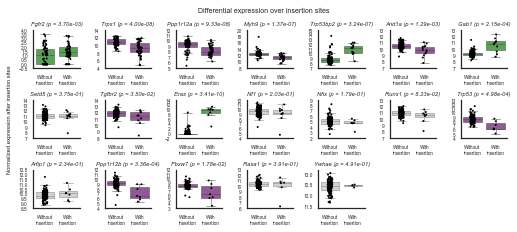

In [48]:
with sns.plotting_context('paper', font_scale=0.6):
    # Plot DE.
    fig, axes = plt.subplots(ncols=7, nrows=3, figsize=(7, 3), sharex=False)

    sel_genes = ranked_genes['gene_name']
    
    for (gene_name, ax) in zip(sel_genes, axes.flatten()):
        result = results[gene_name]

        if result.p_value <= 0.05:
            if result.direction == 1:
                color = sns.color_palette('Set1')[2] # Green
            else:
                color = sns.color_palette('Set1')[3] # Purple
        else:
            color = 'lightgrey'
        
        result.plot_boxplot(log=True, ax=ax, 
                            box_kws={'color': color, 'linewidth': 0.5},
                            strip_kws={'size': 2})
        ax.set_title('{} (p = {:.2e})'.format(gene_name, result.p_value),
                     fontstyle='italic')

        ax.set_xlabel('')
        ax.set_ylabel('')
        
    for ax in axes.flatten():
        ax.set_xticklabels(['Without\ninsertion', 'With\ninsertion'])

    fig.suptitle('Differential expression over insertion sites',
                 fontsize=7, y=1.04)
    
    fig.text(s='Normalized expression after insertion sites',
             rotation=90, x=-0.01, y=0.52, va='center')
    
    axes[-1, -1].axis('off')
    axes[-1, -2].axis('off')
    
    fig.tight_layout()
    sns.despine(fig)

fig.savefig('../reports/supplemental/figures/fig_s5_diff_expr.pdf', bbox_inches='tight')

# KEGG enrichment

In [29]:
from nbsupport.enrichment import genesets as nb_genes

# Fetch gene sets and translate to symbol.
kegg_sets = nb_genes.kegg.get_gene_sets('mmu')
kegg_sets = nb_genes.map_sets(
    kegg_sets, from_type='entrez', to_type='symbol',
    from_organism='mmusculus', mapper='ensembl')

# Test for enrichment.
genes = set(insertions['gene_name'])

result = nb_genes.test_sets(
    set(insertions['gene_name']), kegg_sets,
    corr_method='fdr_bh', include_overlap=True)

result_sign = (
    result.query('p_value_corr < 0.1')
          .sort_values(['p_value', 'p_value_corr']))

result_sign

,gene_set,p_value,p_value_corr,overlap
30,MAPK signaling pathway,0.000005,0.001563,"Fgfr2, Nf1, Rasa1, Rasgrf1, Tgfbr2, Trp53"
2,Chronic myeloid leukemia,0.000011,0.001628,"Cblb, Runx1, Tgfbr2, Trp53"
45,Proteoglycans in cancer,0.000032,0.003260,"Cblb, Gab1, Ppp1r12a, Ppp1r12b, Trp53"
165,Ras signaling pathway,0.000057,0.004306,"Fgfr2, Gab1, Nf1, Rasa1, Rasgrf1"
242,EGFR tyrosine kinase inhibitor resistance,0.000498,0.030082,"Fgfr2, Gab1, Nf1"
128,Regulation of actin cytoskeleton,0.000724,0.031696,"Fgfr2, Myh9, Ppp1r12a, Ppp1r12b"
133,Pathways in cancer,0.000735,0.031696,"Cblb, Fgfr2, Runx1, Tgfbr2, Trp53"
193,Neurotrophin signaling pathway,0.001741,0.065726,"Gab1, Trp53, Ywhae"


In [30]:
result.ix[result['gene_set'].str.contains('PI3K')]

,gene_set,p_value,p_value_corr,overlap
64,PI3K-Akt signaling pathway,0.027169,0.390716,"Fgfr2, Trp53, Ywhae"


In [31]:
! mkdir -p ../reports/tables/
(result_sign.rename(columns={'gene_set': 'Gene set',
                             'p_value': 'p-value',
                             'p_value_corr': 'FDR',
                             'overlap': 'Overlapping genes'})
            .to_excel('../reports/tables/table_1_kegg.xlsx', index=False))

# Mutual exclusivity

In [98]:
try:
    import discover
except ImportError:
    ! cd ../tmp && git clone https://github.com/NKI-CCB/DISCOVER.git
    ! pip install ../tmp/DISCOVER/python
    ! rm -rf ../tmp/DISCOVER
    
# Convert to boolean matrix.
ins_mat = pd.pivot_table(
    insertions, index='gene_name', columns='sample',
    values='support', aggfunc='max', fill_value=0)
ins_mat = (ins_mat > 0).astype(int)

# Test pairwise mutex.
events = discover.DiscoverMatrix(ins_mat)
result_mutex = discover.pairwise_discover_test(events)
result_mutex.significant_pairs(q_threshold=0.25).sort_values('pvalue')

/home/NFS/users/j.d.ruiter/.anaconda3/envs/sb-screen/lib/python3.5/site-packages/discover/pairwise.py:109: RuntimeWarning: invalid value encountered in less
  i, j = numpy.where(self.pi0 * numpy.asarray(self.qvalues) < q_threshold)


,gene1,gene2,pvalue,qvalue
5,Ppp1r12a,Trp53bp2,0.009052,0.181943
4,Ppp1r12a,Ppp1r12b,0.018409,0.181943
3,Myh9,Trp53bp2,0.022027,0.181943
2,Myh9,Ppp1r12a,0.026523,0.181943
0,Fgfr2,Rasgrf1,0.026745,0.181943
1,Myh9,Nf1,0.030593,0.184622


In [95]:
# Test group-wise for this larger group.
genes = ["Myh9", "Trp53bp2", "Ppp1r12a", "Ppp1r12b"]
discover.groupwise_discover_test(events[genes])

0.00017451502496924475

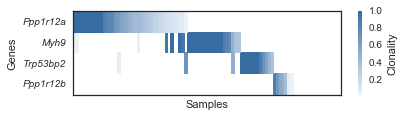

In [96]:
# Plot.
mutex_genes = ['Ppp1r12a', 'Myh9', 'Trp53bp2', 'Ppp1r12b']

fig, ax = plt.subplots(figsize=(6, 1.5))
nb_ins.plot_insertion_matrix(insertions, genes=mutex_genes, ax=ax);

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(3.8, 0.75))
    nb_ins.plot_insertion_matrix(insertions, genes=mutex_genes, ax=ax)

fig.savefig('../reports/figures/fig_3_mutex.pdf', bbox_inches='tight')
plt.close(fig)